In [33]:
%matplotlib inline
import numpy as np
import sklearn.model_selection
import sklearn.ensemble
import sklearn.svm
import sklearn.utils
import os
import librosa
from tqdm import tqdm
import pandas as pd
import scipy as sp
import scipy.io.wavfile
from skimage.util.shape import view_as_windows

import warnings
import matplotlib.pyplot as plt

In [34]:
## eventually if we have time try to train with windows at least this configuration
def df_to_feat_idx_wind(feat_df, key, fun, window_length):
    X = np.asarray(feat_df[key].values)
    Y_v = np.asarray(feat_df['y_value'])
    Y_l = np.asarray(feat_df['y_label'])
    XX = []
    YY_v = []
    YY_l = []
    wind_number = []
    if key == 'mfcc':
        for i, x in enumerate(X):
            x = np.asarray(x).T.squeeze()
            xw = view_as_windows(x, window_shape=(window_length, x.shape[1]),
                                 step=(int(window_length * 0.5), x.shape[1])).squeeze()
            fun_xw = fun(xw).squeeze()
            XX.append(fun_xw)
            wind_number.append(fun_xw.shape[0])

        XX = np.asarray(np.concatenate(XX, axis=0))        
        
    else:
        for i, x in enumerate(X):
            x = np.asarray(x).squeeze()
            xw = view_as_windows(x, window_shape=(window_length,), step=int(window_length * 0.5))
            fun_xw = fun(xw)
            fun_xw = fun_xw.reshape(-1, 1)
            XX.append(fun_xw)
            wind_number.append(fun_xw.shape[0])


        XX = np.asarray(np.concatenate(XX, axis=0))


    return XX, np.array(wind_number)



def df_to_feat_idx(feat_df, key, fun):
    # take only samples of the key feature over the rms threshold
    X = feat_df.apply(lambda x: np.asarray(x[key]).squeeze().T[np.where(x['rms_idx'] == 1)].T, axis=1)
    # apply the function
    X = X.apply(fun)
    X = X.apply(lambda x: np.reshape(x, (1, -1)))
    X = np.concatenate(X).squeeze()
    if len(X.shape) == 1:
        X.shape += (1,)
    return X

## Load the best model and RAI features

In [35]:
import pickle
pkl_filename = '/nas/home/cborrelli/speech_forensics/models/win_cl.pkl'
with open(pkl_filename, 'rb') as file:  
    cl = pickle.load(file)

pkl_filename = '/nas/home/cborrelli/speech_forensics/models/win_mcl.pkl'
with open(pkl_filename, 'rb') as file:  
    mcl = pickle.load(file)
    
pkl_filename = '/nas/home/cborrelli/speech_forensics/models/win_r.pkl'
with open(pkl_filename, 'rb') as file:  
    r = pickle.load(file)

In [36]:
res_file_name = 'rai_features.pkl'
feat_df = pd.read_pickle(os.path.join('/nas/home/cborrelli/speech_forensics/notebook/pickle/', res_file_name))

## Test on RAI

In [37]:
# we can't filter outliers
filter_outliers = False
win_min_max = True
n_win_min = 20
n_win_max = 250
norm = 'zscore'

win_feature_length = [10, 12, 14, 16, 18, 20]

# Shuffle the dataset
feat_df = sklearn.utils.shuffle(feat_df, random_state=0).reset_index(drop=True)

# Apply rms threshold
feat_df['n_win'] = feat_df['rms'].apply(lambda x: len(x))

# Select files long enough
if win_min_max:
    feat_df = feat_df.loc[np.where(np.logical_and(feat_df['n_win'] >= n_win_min, feat_df['n_win'] <= n_win_max))[0]].reset_index()

In [38]:
# Compute feature matrix
key_list = ['mfcc', 'sfl', 'sc', 'sroff', 'zcr', 'rms']

for w in tqdm(win_feature_length, total=len(win_feature_length)):
    X_mean_list = []
    for key in key_list:
        X_m, _= df_to_feat_idx_wind(feat_df, key, lambda x: np.mean(x, axis=1), window_length=w)
        X_mean_list += [X_m]

    X_mean = np.concatenate(X_mean_list, axis=1)

    X_std_list = []
    for key in key_list:
        X_s, _= df_to_feat_idx_wind(feat_df, key, lambda x: np.std(x, axis=1), window_length=w)
        X_std_list += [X_s]
    X_std = np.concatenate(X_std_list, axis=1)

    X_max_list = []
    for key in key_list:
        X_m, _ = df_to_feat_idx_wind(feat_df, key, lambda x: np.max(x, axis=1), window_length=w)
        X_max_list += [X_m]
    X_max = np.concatenate(X_max_list, axis=1)

    X_min_list = []
    for key in key_list:
        X_m, wind_number = df_to_feat_idx_wind(feat_df, key, lambda x: np.min(x, axis=1),
                                                    window_length=w)
        X_min_list += [X_m]
    X_min = np.concatenate(X_min_list, axis=1)

    X = np.concatenate([X_mean, X_std, X_max, X_min], axis=1)

    # Retrieve labels
    y_mcl = np.array(feat_df['y_label'], dtype=np.float)  # labels for classification
    y_cl = np.array(feat_df['y_bin_label'], dtype=np.float)  # labels for classification
    
    
    y_mcl = np.repeat(y_mcl, wind_number)
    y_cl = np.repeat(y_cl, wind_number)
    
    # Retrieve properties
    snrs = feat_df['snr']
    snrs = [item for item, count in zip(snrs, wind_number) for i in range(count)]
    
    noises = feat_df['noise']
    noises = [item for item, count in zip(noises, wind_number) for i in range(count)]

    # Normalize features
    if norm == 'zscore':
        X_norm = (X - X.mean(axis=0)) / X.std(axis=0)  # z-score
    elif norm == 'minmax':
        X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))  # [0, 1]
    else:
        X_norm = X

    # Remove nan and inf
    X_norm[np.where(np.isnan(X_norm))] = 0
    X_norm[np.where(np.isinf(X_norm))] = 0
    
    
    # Test
    y_pred_mcl = mcl.predict(X_norm)
    y_pred_r = r.predict(X_norm)
    
    y_pred_cl = y_pred_r >= 0.5  # labels for classification

   
    columns = ['noise', 'snr', 'y_bin_label', 'y_label',  'y_pred_cl','y_pred_mcl', 'y_pred_r']
    res_df = pd.DataFrame(columns=columns)
    res_df.loc[:, 'noise'] = noises
    res_df.loc[:, 'snr'] = snrs
    res_df.loc[:, 'y_bin_label'] = y_cl
    res_df.loc[:, 'y_label'] = y_mcl
    res_df.loc[:, 'y_pred_mcl'] = y_pred_mcl
    res_df.loc[:, 'y_pred_cl'] = y_pred_cl
    res_df.loc[:, 'y_pred_r'] = y_pred_r

    res_name = 'rai_results_windowlength-' + str(w) +'.pkl'
    res_df.to_pickle(os.path.join('/nas/home/cborrelli/speech_forensics/rai/results', res_name))


  0%|          | 0/6 [00:00<?, ?it/s]/nas/home/cborrelli/miniconda/lib/python3.7/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
 17%|█▋        | 1/6 [01:26<07:11, 86.36s/it]/nas/home/cborrelli/miniconda/lib/python3.7/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
 33%|███▎      | 2/6 [02:36<05:25, 81.37s/it]/nas/home/cborrelli/miniconda/lib/python3.7/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
 50%|█████     | 3/6 [03:33<03:42, 74.17s/it]/nas/home/cborrelli/miniconda/lib/python3.7/site-packages/skimage/util/shape.py:246: RuntimeWarning

In [32]:
res_df

,noise,snr,y_bin_label,y_label,y_pred_cl,y_pred_mcl,y_pred_r
0,rai,None,1.0,2.0,False,0.0,0.401991
1,rai,None,1.0,2.0,False,0.0,0.401991
2,rai,None,1.0,2.0,False,0.0,0.401991
3,rai,None,1.0,2.0,False,0.0,0.401991
4,rai,None,1.0,2.0,False,0.0,0.401991
5,rai,None,1.0,2.0,False,0.0,0.401991
6,rai,None,1.0,2.0,False,0.0,0.401991
7,rai,None,0.0,0.0,False,0.0,0.401991
8,rai,None,0.0,0.0,False,0.0,0.401991
9,rai,None,0.0,0.0,False,0.0,0.401991


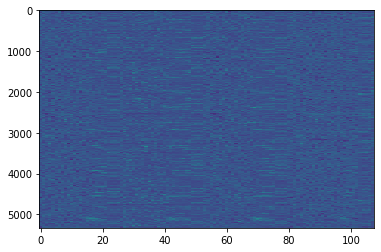

In [28]:
plt.imshow(X_norm, aspect='auto')

## Evaluate

In [29]:
import sklearn.metrics
import matplotlib.pyplot as plt

Window length: 10
0.3557589761820121
0.3557589761820121
0.472182723071454
0.472182723071454
Window length: 12
0.3551894918173988
0.3551894918173988
0.4720068906115418
0.4720068906115418
Window length: 14
0.3555386372287781
0.35553863722877815
0.47252886689506407
0.47252886689506407
Window length: 16
0.35551638019685616
0.3555163801968561
0.4728955486998678
0.4728955486998678
Window length: 18
0.3557628247834777
0.3557628247834777
0.47285143237841437
0.47285143237841437
Window length: 20
0.35735735735735735
0.35735735735735735
0.4739114114114114
0.4739114114114114


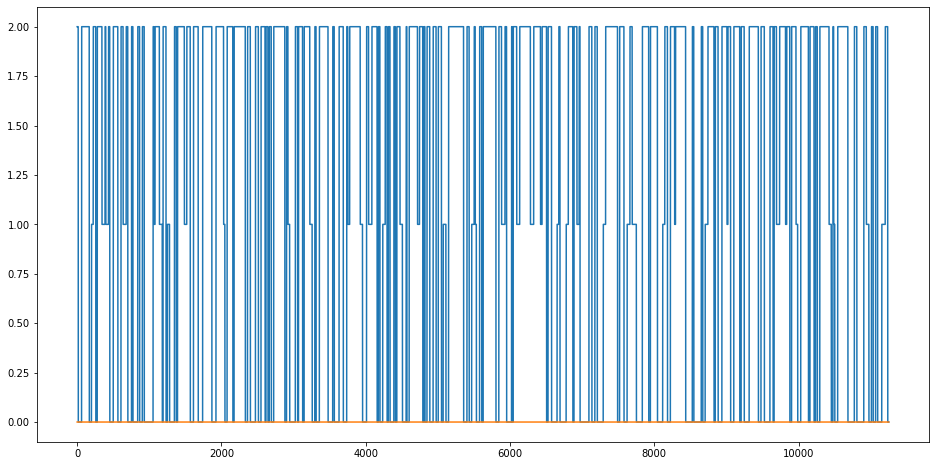

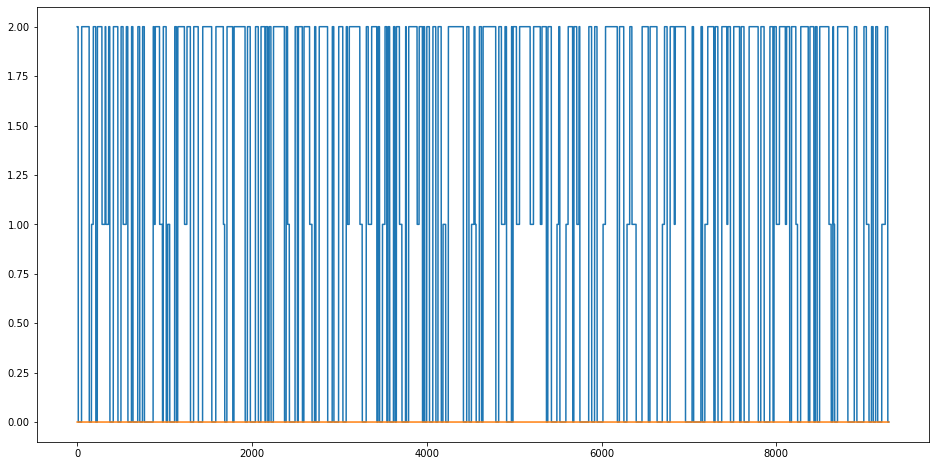

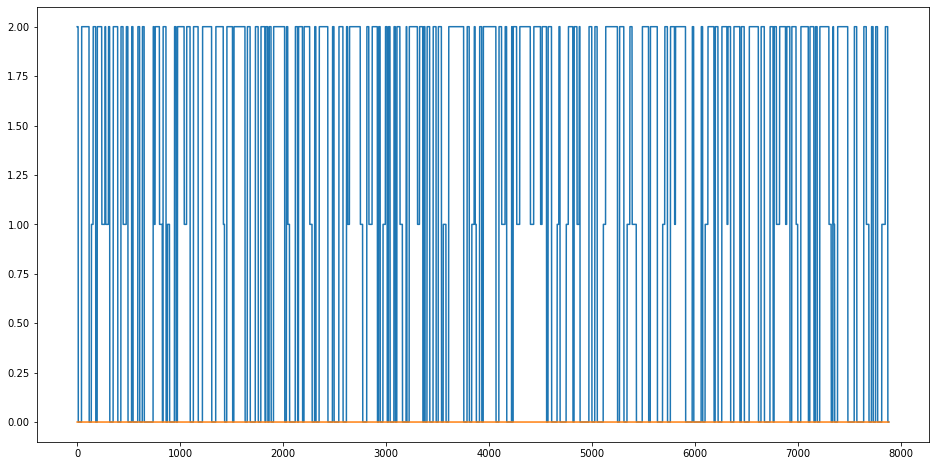

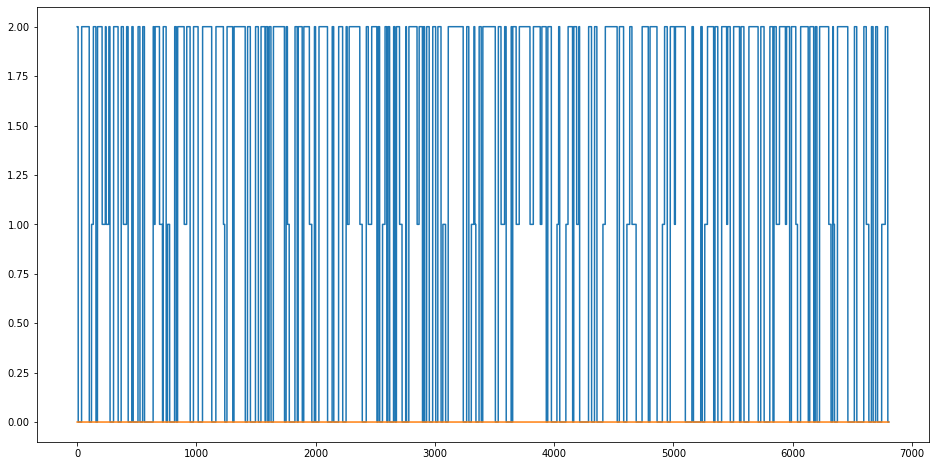

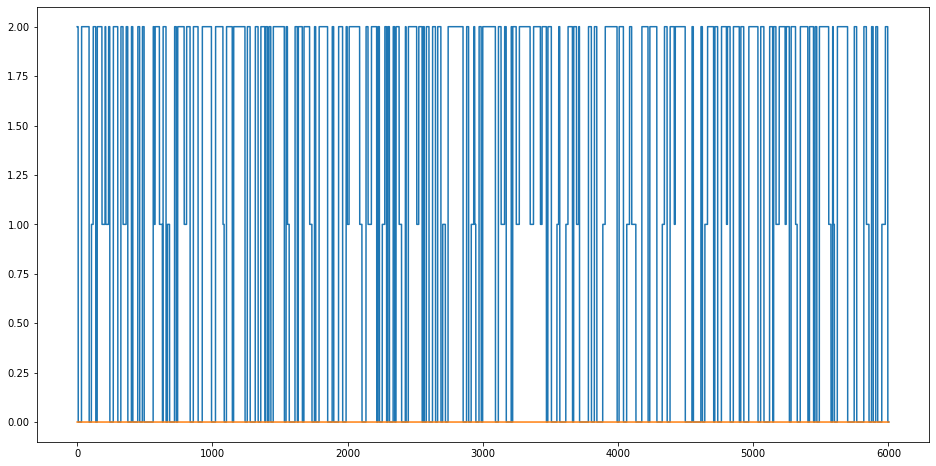

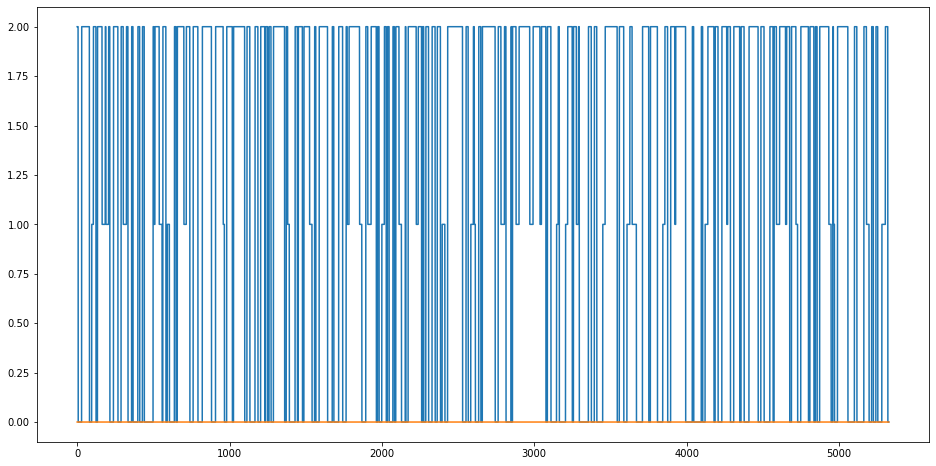

In [30]:
for w in win_feature_length:
    res_name = 'rai_results_windowlength-' + str(w) +'.pkl'
    res = pd.read_pickle(os.path.join('/nas/home/cborrelli/speech_forensics/rai/results',res_name))

    y_mcl = res['y_label'] 
    y_cl = res['y_bin_label']
    y_pred_mcl = res['y_pred_mcl']
    y_pred_cl = res['y_pred_cl']
    
    # Use the regression results for binary classifier
    
    plt.figure(figsize=(16,8))
    plt.plot(y_mcl)
    plt.plot(y_pred_mcl)
    
    
    mcl_balanced_accuracy = sklearn.metrics.accuracy_score(y_mcl, y_pred_mcl)
    mcl_f1= sklearn.metrics.f1_score(y_mcl, y_pred_mcl, average='micro')

    r_cl_balanced_accuracy = sklearn.metrics.accuracy_score(y_cl, y_pred_cl)
    r_cl_f1 = sklearn.metrics.f1_score(y_cl, y_pred_cl, average='micro')
    
    print('Window length: ' + str(w) )
    print(mcl_balanced_accuracy)
    print(mcl_f1)
    print(r_cl_balanced_accuracy)
    print(r_cl_f1)




In [23]:
y_cl

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
10       1.0
11       1.0
12       1.0
13       1.0
14       1.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
11222    1.0
11223    1.0
11224    1.0
11225    1.0
11226    1.0
11227    1.0
11228    1.0
11229    1.0
11230    1.0
11231    1.0
11232    1.0
11233    1.0
11234    1.0
11235    1.0
11236    0.0
11237    0.0
11238    0.0
11239    0.0
11240    0.0
11241    0.0
11242    0.0
11243    0.0
11244    0.0
11245    0.0
11246    0.0
11247    0.0
11248    0.0
11249    0.0
11250    0.0
11251    0.0
Name: y_bin_label, Length: 11252, dtype: float64

In [24]:
y_pred_cl

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
11222    NaN
11223    NaN
11224    NaN
11225    NaN
11226    NaN
11227    NaN
11228    NaN
11229    NaN
11230    NaN
11231    NaN
11232    NaN
11233    NaN
11234    NaN
11235    NaN
11236    NaN
11237    NaN
11238    NaN
11239    NaN
11240    NaN
11241    NaN
11242    NaN
11243    NaN
11244    NaN
11245    NaN
11246    NaN
11247    NaN
11248    NaN
11249    NaN
11250    NaN
11251    NaN
Name: y_pred_cl, Length: 11252, dtype: object